## DL4CV Mid-Term Project (Spring, 2022)
###### Gerald McCollam

### Requirements
This project has been developed to run on Google Colab as an Jupyter notebook. No dependencies beyond what Colab supplies are required. It is recommended that the Colab runtime be set to 'GPU' and 'High Ram' but it will execute fine if these are unset. 

If a library is missing it may be installed into a Colab session with the following:  

```bash
!pip install <library>
```

If a runtime error occurs it is likely related to connection issues between Colab and Google Drive, or to input data not being available in the required form. The instructors have provided no guidance regarding how the GTSRB dataset should be made available for this assignment to run in a different environment; this has been left to the student to determine. 

#### Data Loading
First, if running Colab with Drive, create the directory 'DL4CV-2022' in your home directory and clone [this Github repository](git@github.com:geraldmc/DL4CV-2022.git) into DL4CV-2022. Your gdrive_path to the project should then look like the following:  

    gdrive_path = '/content/drive//MyDrive/DL4CV-2022/project-I/'

The notebook will attempt to load three zipped data files. 

    zip_path_train = gdrive_path + 'data/Final_Training.zip'
    zip_path_val = gdrive_path + 'data/Final_Validation.zip'
    zip_path_test = gdrive_path + 'data/Final_Test.zip'

Two of these (Final_Training.zip, Final_Test.zip) have been created by downloading from the GTSRB download site. The files used for the assignment are:

[GTSRB_Final_Training_Images.zip](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip)

[GTSRB_Final_Test_Images.zip](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip)

The directory structure for the unzipped files is the following:

```
- Final_Training
  - Annotations
    - GT_Training.csv (this file is required)
    - GT-00000.csv
    - GT-00001.csv
  - Images
    - 00000
      - 00000_00000.ppm
      - 00000_00001.ppm
    - 00001
      - 00000_00000.ppm
      - 00000_00001.ppm
    - ...

- Final_Test
  - Images
    - 01089.ppm
    - 01090.ppm
    - ...
```
The file 'Final_Validation.zip' was created by using images 00000\*, 00001\* and 00002\* from each class in the training set. There are 23,220 files in the augmented validation set and 3,900 in the unaugmented set.   

#### Running 
Execute the Jupyter notebook `DL4CV-2022/project-I/main.ipynb`. It will run to completion using the `Run All` command in Colab.

#### Issues
If there are any questions please do not hesitate to text me at gerald.mccollam@gmail.com.

In [1]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

In [2]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys

COLAB = 'google.colab' in str(get_ipython())
HAS_GPU = torch.cuda.is_available()
is_local = not COLAB

if COLAB: # running on Colab
    
    from google.colab import drive
    drive.flush_and_unmount()
    
    drive.mount('/content/drive', force_remount=True)
    gdrive_path = '/content/drive//MyDrive/DL4CV-2022/project-I/'
    sys.path.append(gdrive_path)

    zip_path_train = gdrive_path + 'data/Final_Training.zip'
    zip_path_val = gdrive_path + 'data/Final_Validation.zip'
    zip_path_test = gdrive_path + 'data/Final_Test.zip'
    !unzip -q "{zip_path_train}"
    !unzip -q "{zip_path_val}"
    !unzip -q "{zip_path_test}"
    
    if HAS_GPU:
        print("Using GPU")
else:
    HAS_GPU = False
    print("Using CPU")

# If we run cuda then accomodate these datatypes.
FloatTensor = torch.cuda.FloatTensor if HAS_GPU else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if HAS_GPU else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if HAS_GPU else torch.ByteTensor
Tensor = FloatTensor

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
Using GPU


In [4]:
import loader.args as load_args
args = load_args.get_args(is_local)

TRAIN_DATA_PATH = args.data_dir_train
VAL_DATA_PATH = args.data_dir_val
TEST_DATA_PATH = args.data_dir_test
BATCH_SIZE = args.batch_size
EPOCHS = args.num_epochs
BATCH_SIZE = args.batch_size
LEARNING_RATE = args.learning_rate

In [5]:
from loader import transforms as tfs
from torch.utils.data import Dataset
from loader.gtsrb_data import GTSRB_Test
from utils.tensor2image import imshow

train_data = datasets.ImageFolder(
    root=TRAIN_DATA_PATH, 
    transform=tfs.base_transform)
train_loader = data.DataLoader(train_data, 
    batch_size=BATCH_SIZE, shuffle=True,  
    num_workers=2)

val_data = datasets.ImageFolder(
    root=VAL_DATA_PATH, 
    transform=tfs.base_transform)
val_loader  = data.DataLoader(val_data, 
    batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2)

In [6]:
if COLAB:
    GTSRB_test_dataset = GTSRB_Test('/content/')
    
else:
    GTSRB_test_dataset = GTSRB_Test('data/')

assert len(GTSRB_test_dataset) == 12630

test_loader = data.DataLoader(GTSRB_test_dataset, 
    batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2)

In [7]:
# Without augmentation
assert len(train_loader)*50 == 39250
assert len(val_loader)*50 == 3900
assert len(test_loader)*50 == 12650
print()
print('Unaugmented dataset: %d training samples & %d validation samples\n' % (
len(train_loader)*args.batch_size, len(val_loader)*args.batch_size))


Unaugmented dataset: 39250 training samples & 3900 validation samples



In [8]:
from model.models import Net1

# Reset everything
model = None
optimizer = None
scheduler = None

model = Net1()
if HAS_GPU:
    model.cuda()

# Optimizer is updated to *not* include non-gradient weights.    
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                                      lr=args.learning_rate)
# Reduce learning rate when a metric has stopped improving. 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 patience=5,
                                                 factor=0.5,
                                                 verbose=True)

In [9]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10          [-1, 100, 28, 28]           7,600
      BatchNorm2d-11          [-1, 100, 14, 14]             200
        Dropout2d-12          [-1, 100, 14, 14]               0
           Conv2d-13          [-1, 150, 12, 12]         135,150
      BatchNorm2d-14            [-1, 15

In [10]:
from utils.meter import AvgMeter, calc_accuracy

train_losses = []
train_accuracies = []

'''
    .                       o8o
  .o8                       `"'
.o888oo oooo d8b  .oooo.   oooo  ooo. .oo.
  888   `888""8P `P  )88b  `888  `888P"Y88b
  888    888      .oP"888   888   888   888
  888 .  888     d8(  888   888   888   888
  "888" d888b    `Y888""8o o888o o888o o888o
'''

def train(epoch):
    print()
    print('Epoch {} -------------------------------------------------------->'.format(epoch) )
    print()
    losses = AvgMeter()
    accuracies = AvgMeter()
    model.train()
    correct = 0
    training_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if HAS_GPU:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        losses.update(loss.item(), data.size(0))
        accuracy = calc_accuracy(output, target)[0]
        train_accuracies.append(int(accuracy))
        accuracies.update(accuracy, data.size(0))
        
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1] # _, predicted
        correct += (max_index == target).sum()
        training_loss += loss
        
        if batch_idx % args.log_interval == 0:
            print('Training set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            losses.avg, int(accuracies.sum/100), accuracies.count, accuracies.avg))
    
    return train_accuracies

In [11]:
val_losses = []
val_accuracies = []

'''
                      oooo
                      `888
oooo    ooo  .oooo.    888
 `88.  .8'  `P  )88b   888
  `88..8'    .oP"888   888
   `888'    d8(  888   888
    `8'     `Y888""8o o888o
'''

def validate(epoch):
    losses = AvgMeter()
    accuracies = AvgMeter()
    error_cases = []
    
    model.eval() # changes the forward() behaviour of the module for val/test.
    
    with torch.no_grad(): # disable tracking of gradients in autograd.
        for data, target in val_loader:
            if HAS_GPU:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = F.nll_loss(output, target)

            losses.update(loss.item(), data.size(0))
            accuracy = calc_accuracy(output, target)[0]
            val_accuracies.append(accuracy)
            accuracies.update(accuracy, data.size(0))

            _, pred = output.topk(1, 1, True, True)
            pred = pred.t()

        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            losses.avg, int(accuracies.sum/100), accuracies.count, accuracies.avg))

    return val_accuracies

In [12]:
import numpy as np
import pandas as pd
import sklearn.metrics as sm

'''
    .                          .
  .o8                        .o8
888oo  .ooooo.   .oooo.o .o888oo
  888   d88' `88b d88(  "8   888
  888   888ooo888 `"Y88b.    888
  888 . 888    .o o.  )88b   888 .
  "888" `Y8bod8P' 8""888P'   "888"
'''

def test(test_loader):
    model.eval()
    correct = 0
    targets, preds = [], []
    
    with torch.no_grad():
        for data, target in test_loader:
            if HAS_GPU:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

    test_acc = 100. * correct / len(test_loader.dataset)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    return test_acc, confusion_mtx

In [13]:
training_accuracy = []
validation_accuracy = []
test_accuracy = []
confusion = [] 

for epoch in range(1, args.num_epochs + 1):
    training_accuracy.append(train(epoch))
    validation_accuracy.append(validate(epoch))
    test_acc, confusion_mtx = test(test_loader)
    test_accuracy.append(test_acc)
    confusion.append(confusion_mtx)
    print()
    print('\r --> Testing set: Accuracy (Best) = %2.2f%%' % max(test_accuracy), 
          end='', flush=True)
    print()

#model_file = 'model_' + str(epoch) + '.pth'
#torch.save(model.state_dict(), model_file)


Epoch 1 -------------------------------------------------------->

Training set: Average loss: 3.9831, Accuracy: 1/50 (2.000%)

Training set: Average loss: 3.4322, Accuracy: 1142/10050 (11.363%)

Training set: Average loss: 3.0702, Accuracy: 3943/20050 (19.666%)

Training set: Average loss: 2.7371, Accuracy: 8204/30050 (27.301%)


Validation set: Average loss: 1.5650, Accuracy: 2215/3870 (57.24%)


 --> Testing set: Accuracy (Best) = 73.78%

Epoch 2 -------------------------------------------------------->

Training set: Average loss: 1.3632, Accuracy: 33/50 (66.000%)

Training set: Average loss: 1.0855, Accuracy: 6996/10050 (69.612%)

Training set: Average loss: 0.9349, Accuracy: 14859/20050 (74.110%)

Training set: Average loss: 0.8157, Accuracy: 23275/30050 (77.454%)


Validation set: Average loss: 0.3412, Accuracy: 3542/3870 (91.52%)


 --> Testing set: Accuracy (Best) = 92.65%

Epoch 3 -------------------------------------------------------->

Training set: Average loss: 0.3802, 

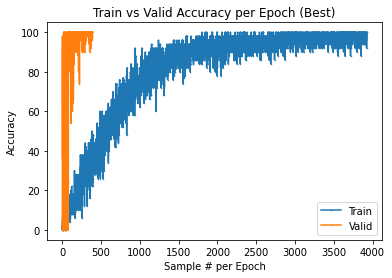

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(training_accuracy[0],'-o', markersize=.5)
plt.plot(validation_accuracy[0],'-o', markersize=.5)
plt.xlabel('Sample # per Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy per Epoch (Best)')
None
# Reset
training_accuracy = None
validation_accuracy = None

Dataset: 39209 training samples & 12630 testing samples

Distribution of classes in training dataset:


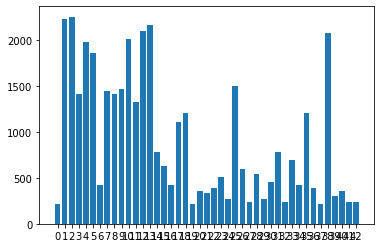

In [15]:
import matplotlib.pyplot as plt
print('Dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in training dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset.imgs]
class_labels, counts = np.unique(labels, return_counts=True)
ax.bar(class_labels, counts)
ax.set_xticks(class_labels)
plt.show()

In [16]:
idx2class = {v: k for k, v in train_data.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

class_distro = get_class_distribution(train_data)
print("Distribution of classes ranges from {} to {}.".format
      (min(class_distro.values()), max(class_distro.values())))


Distribution of classes ranges from 210 to 2250.


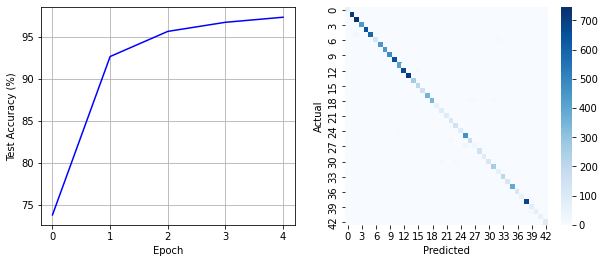

In [17]:
from utils.visualize import visual

visual(test_accuracy, confusion, class_labels)

In [18]:
from loader.imbalanced import ImbalancedDatasetSampler
from loader import transforms as tfs
from torch.utils.data import Dataset
from loader.gtsrb_data import GTSRB_Test

train_data = None
val_data = None
train_loader = None
val_loader = None
GTSRB_test_dataset = None
test_loader = None

# Reload everything
train_data = datasets.ImageFolder(
    root=TRAIN_DATA_PATH, 
    transform=tfs.base_transform)
train_loader = data.DataLoader(train_data, 
    batch_size=BATCH_SIZE, 
    sampler=ImbalancedDatasetSampler(train_data), 
    num_workers=2)

val_data = datasets.ImageFolder(
    root=VAL_DATA_PATH, 
    transform=tfs.base_transform)
val_loader = data.DataLoader(val_data, 
    batch_size=BATCH_SIZE, 
    sampler=ImbalancedDatasetSampler(val_data), # <----- data sampler
    num_workers=2)

if COLAB:
    GTSRB_test_dataset = GTSRB_Test('/content/')
    
else:
    GTSRB_test_dataset = GTSRB_Test('data/')

assert len(GTSRB_test_dataset) == 12630

test_loader = data.DataLoader(GTSRB_test_dataset, 
    batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2)


In [19]:
from model.models import Net1

# Reset
model = None
optimizer = None
scheduler = None

model = Net1()
if HAS_GPU:
    model.cuda()

# Optimizer is updated to *not* include non-gradient weights.    
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                                      lr=args.learning_rate)
# Reduce learning rate when a metric has stopped improving. 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 patience=5,
                                                 factor=0.5,
                                                 verbose=True)

In [20]:
# Reset
training_accuracy = []
validation_accuracy = []
test_accuracy = []
confusion = [] 
test_acc = None
confusion_mtx = None
epoch = None

for epoch in range(1, args.num_epochs + 1):
    training_accuracy.append(train(epoch))
    validation_accuracy.append(validate(epoch))
    test_acc, confusion_mtx = test(test_loader)
    test_accuracy.append(test_acc)
    confusion.append(confusion_mtx)
    print()
    print('\r --> Testing set: Accuracy (Best) = %2.2f%%' % max(test_accuracy), 
          end='', flush=True)
    print()
    
#model_file = 'model_' + str(epoch) + '.pth'
#torch.save(model.state_dict(), model_file)


Epoch 1 -------------------------------------------------------->

Training set: Average loss: 3.8296, Accuracy: 1/50 (2.000%)

Training set: Average loss: 3.5941, Accuracy: 682/10050 (6.786%)

Training set: Average loss: 3.3174, Accuracy: 2522/20050 (12.579%)

Training set: Average loss: 2.9982, Accuracy: 6127/30050 (20.389%)


Validation set: Average loss: 1.0880, Accuracy: 3048/3870 (78.76%)


 --> Testing set: Accuracy (Best) = 71.11%

Epoch 2 -------------------------------------------------------->

Training set: Average loss: 1.3395, Accuracy: 33/50 (66.000%)

Training set: Average loss: 1.1339, Accuracy: 6981/10050 (69.463%)

Training set: Average loss: 0.9817, Accuracy: 14760/20050 (73.616%)

Training set: Average loss: 0.8608, Accuracy: 23137/30050 (76.995%)


Validation set: Average loss: 0.2402, Accuracy: 3755/3870 (97.03%)


 --> Testing set: Accuracy (Best) = 91.05%

Epoch 3 -------------------------------------------------------->

Training set: Average loss: 0.3913, Ac

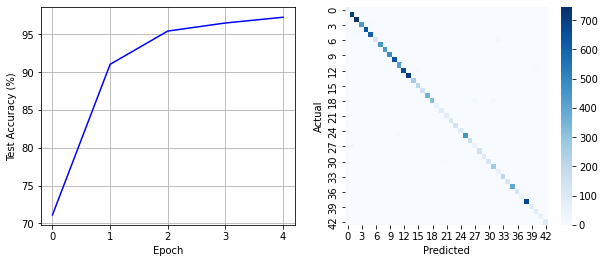

In [21]:
from utils.visualize import visual

visual(test_accuracy, confusion, class_labels)

In [22]:
train_loader = None
val_loader = None

train_loader = torch.utils.data.DataLoader(
 torch.utils.data.ConcatDataset([datasets.ImageFolder(
                                    TRAIN_DATA_PATH, 
                                    transform=tfs.base_transform),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_translate),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_grayscale),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_center),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_rotate),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_jitter_hue)]), 
                                    batch_size=args.batch_size, 
                                    shuffle=True, num_workers=2, 
                                    pin_memory=HAS_GPU)

val_loader = torch.utils.data.DataLoader(
 torch.utils.data.ConcatDataset([datasets.ImageFolder(
                                    VAL_DATA_PATH, 
                                    transform=tfs.base_transform),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_translate),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_grayscale),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_center),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_rotate),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_jitter_hue)]), 
                                    batch_size=args.batch_size, 
                                    shuffle=False, num_workers=2, 
                                    pin_memory=HAS_GPU)

if COLAB:
    GTSRB_test_dataset = GTSRB_Test('/content/')
    
else:
    GTSRB_test_dataset = GTSRB_Test('data/')

assert len(GTSRB_test_dataset) == 12630

test_loader = data.DataLoader(GTSRB_test_dataset, 
    batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2)

Augmented dataset: 235254 training samples & 23220 validation samples

Distribution of classes in augmented train dataset:


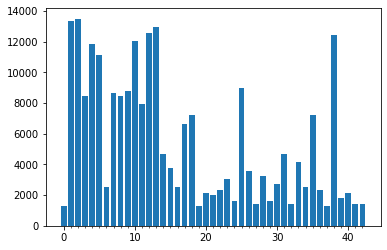

In [23]:
print('Augmented dataset: %d training samples & %d validation samples\n' % (
    len(train_loader.dataset), len(val_loader.dataset)))

# Get labels from concatenated datasets.
train_dataset_list = train_loader.dataset.datasets
train_concat_labels = []
for ds in train_dataset_list:
    train_concat_labels.extend(ds.targets)

val_dataset_list = val_loader.dataset.datasets
val_concat_labels = []
for ds in val_dataset_list:
    val_concat_labels.extend(ds.targets)

class_labels = range(43)

print('Distribution of classes in augmented train dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_concat_labels, return_counts=True)
ax.bar(class_labels, counts)
ax.set_xticks(class_labels, minor=True)
plt.show()

In [24]:
from model.models import Net1

# Reset
model = None
optimizer = None
scheduler = None

model = Net1()
if HAS_GPU:
    model.cuda()

# Optimizer is updated to *not* include non-gradient weights.    
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                                      lr=args.learning_rate)
# Reduce learning rate when a metric has stopped improving. 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 patience=5,
                                                 factor=0.5,
                                                 verbose=True)

In [25]:
# Reset these
training_accuracy = []
validation_accuracy = []
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

test_accuracy = []
confusion = [] 
test_acc = None
confusion_mtx = None
epoch = None

for epoch in range(1, args.num_epochs + 1):
    training_accuracy.append(train(epoch))
    validation_accuracy.append(validate(epoch))
    test_acc, confusion_mtx = test(test_loader)
    test_accuracy.append(test_acc)
    confusion.append(confusion_mtx)
    print()
    print('\r --> Testing set: Accuracy (Best) = %2.2f%%' % max(test_accuracy), 
          end='', flush=True)
    print()


Epoch 1 -------------------------------------------------------->

Training set: Average loss: 3.9925, Accuracy: 1/50 (2.000%)

Training set: Average loss: 3.4977, Accuracy: 1023/10050 (10.179%)

Training set: Average loss: 3.2514, Accuracy: 3118/20050 (15.551%)

Training set: Average loss: 3.0080, Accuracy: 6361/30050 (21.168%)

Training set: Average loss: 2.7507, Accuracy: 10850/40050 (27.091%)

Training set: Average loss: 2.4987, Accuracy: 16619/50050 (33.205%)

Training set: Average loss: 2.2783, Accuracy: 23289/60050 (38.783%)

Training set: Average loss: 2.0872, Accuracy: 30692/70050 (43.814%)

Training set: Average loss: 1.9227, Accuracy: 38530/80050 (48.132%)

Training set: Average loss: 1.7792, Accuracy: 46789/90050 (51.959%)

Training set: Average loss: 1.6596, Accuracy: 55171/100050 (55.143%)

Training set: Average loss: 1.5531, Accuracy: 63798/110050 (57.972%)

Training set: Average loss: 1.4604, Accuracy: 72587/120050 (60.464%)

Training set: Average loss: 1.3781, Accurac

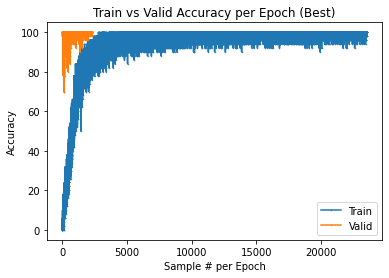

In [26]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(training_accuracy[0],'-o', markersize=.5)
plt.plot(validation_accuracy[0],'-o', markersize=.5)
plt.xlabel('Sample # per Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy per Epoch (Best)')
None
# Reset
training_accuracy = None
validation_accuracy = None

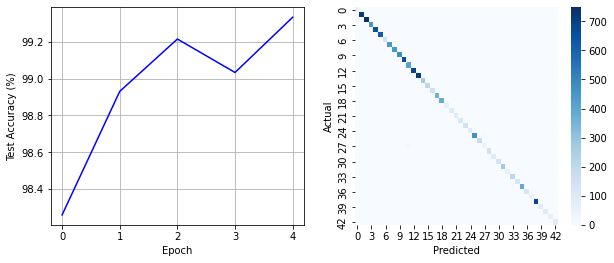

In [27]:
visual(test_accuracy, confusion, class_labels)

In [28]:
# ---------------------------------------------------------------------
# Experiment Demonstrating Precision For Multi-Class Predictions
# ---------------------------------------------------------------------

# Calculate precision for a 1:1:100 dataset (50TP, 20FP, 99TP, 51FP)
from sklearn.metrics import precision_score

# Define actuals
actual_positive1 = [1 for _ in range(100)]
actual_positive2 = [2 for _ in range(100)]
actual_negative = [0 for _ in range(10000)]
y_true = actual_positive1 + actual_positive2 + actual_negative

# Define predictions
predicted_positive1 = [0 for _ in range(50)] + [1 for _ in range(50)]
predicted_positive2 = [0 for _ in range(1)] + [2 for _ in range(99)]
predicted_negative = [1 for _ in range(20)] + [2 for _ in range(51)] + [0 for _ in range(9929)] 
y_pred = predicted_positive1 + predicted_positive2 + predicted_negative

# calculate prediction
prec = precision_score(y_true, y_pred, labels=[1,2], average='micro') 
print('Precision: %.3f' % prec)

Precision: 0.677


In [29]:
# fin